In [ ]:
import pandas as pd
import numpy as np
import gzip
import json
import requests
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Load data into a pandas DataFrame


Download the file and write into `reviews_Digital_Music_5.json.gz`

In [2]:
url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz"
data_file = "reviews_Digital_Music_5.json.gz"
response = requests.get(url, stream=True)
with open(data_file, "wb") as f:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)



Load `reviews_Digital_Music_5.json.gz` into dataframe `df`. Keep only columns `reviewText` and `overall`

In [3]:
def parse_json(file):
    with gzip.open(file, 'rt', encoding='utf-8') as f:
        for line in f:
            yield json.loads(line)

data = list(parse_json(data_file))
df = pd.DataFrame(data)
df = df[['reviewText', 'overall']]
df["reviewText"] = df["reviewText"].astype(str)
df["overall"] = df['overall'].astype(int)
df.head()


,reviewText,overall
0,"It's hard to believe ""Memory of Trees"" came ou...",5
1,"A clasically-styled and introverted album, Mem...",5
2,I never thought Enya would reach the sublime h...,5
3,This is the third review of an irish album I w...,5
4,"Enya, despite being a successful recording art...",4


## 2. Preprocessing & Vectorizing 

Preprocess: Keep only English characters and spaces, lower them and remove stopwords.

In [4]:
#Preprocessing:
stopwords_set = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = text.lower()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords_set]
    return ' '.join(tokens)


In [5]:
df['cleaned_text'] = df['reviewText'].apply(preprocess_text)
df.head()

,reviewText,overall,cleaned_text
0,"It's hard to believe ""Memory of Trees"" came ou...",5,hard believe memory trees came years ago held ...
1,"A clasically-styled and introverted album, Mem...",5,clasically styled introverted album memory tre...
2,I never thought Enya would reach the sublime h...,5,never thought enya would reach sublime heights...
3,This is the third review of an irish album I w...,5,third review irish album write today others cr...
4,"Enya, despite being a successful recording art...",4,enya despite successful recording artist broad...


Vectorize using TfidfVectorizer with 1gram and 2grams.

In [6]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(df['cleaned_text'])
print(vectorizer.get_feature_names_out())
print(X.get_shape())  

['aa' 'aa day' 'aa disco' ... 'zzzzzzzzzzzzzzz im'
 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'
 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz']
(64706, 3007783)


## 3. Building Model

Split the dataset into 80% training dataset and 20% testing dataset

In [7]:
y=df["overall"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Fit into Logistic Regression model.

In [8]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

## 4. Evaluation

In [9]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6300


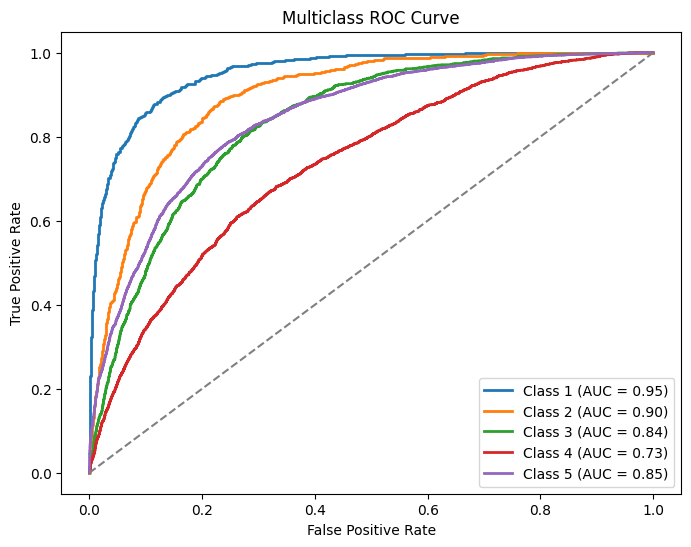

In [10]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_prob = model.predict_proba(X_test)
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()




## Extra: Binary classification (1: 4-5, 0: 1-3)

In [11]:
df["overall"] = df["overall"].apply(lambda x: 0 if x in [1, 2, 3] else 1)
y=df["overall"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8540
